In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df=pd.read_csv('/content/train.csv')

Data Overview

In [47]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [48]:
df.shape

(5574, 2)

Check Missing values

In [49]:
df.isnull().sum()

,0
sms,0
label,0


# Text Preprocessing

Text Lowercasing

In [50]:
df['sms']=df['sms'].str.lower()

In [51]:
df.head()

,sms,label
0,"go until jurong point, crazy.. available only ...",0
1,ok lar... joking wif u oni...\n,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor... u c already then say...,0
4,"nah i don't think he goes to usf, he lives aro...",0


Remove HTML tags

In [52]:
from bs4 import BeautifulSoup

def remove_html(text):
  soup=BeautifulSoup(text,'html.parser')
  clean_text=soup.get_text()
  clean_text=' '.join(clean_text.split())
  return clean_text

df['sms']=df['sms'].apply(remove_html)


Remove URLs

In [53]:
df['sms']=df['sms'].str.replace(r"https?://\S+|www\.\S+"," ",regex=True)

Remove Hashtag And Mention

In [54]:
df['sms']=df['sms'].str.replace(r"[@#]\w+",'',regex=True)

Remove Irrelevant Punctuation,Special Characters,Underscore,Emoji (if exist)

In [55]:
df['sms']=df['sms'].str.replace(r"[^a-z0-9!%$?\s]"," ",regex=True)

Remove whitespace

In [56]:
df['sms']=df['sms'].str.replace(r'\s+',' ',regex=True).str.strip()



In [57]:
df.head()

,sms,label
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor u c already then say,0
4,nah i don t think he goes to usf he lives arou...,0


Data Distribution

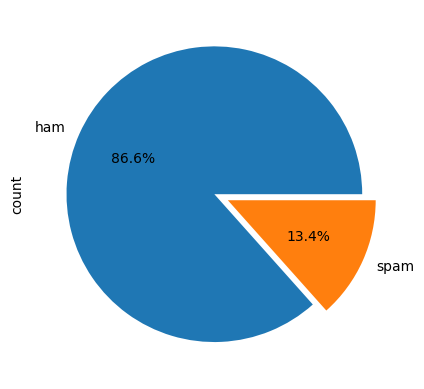

In [58]:
df['label'].value_counts().plot(kind='pie',explode = [0, 0.1],labels=['ham','spam'],autopct='%0.1f%%')
plt.show()

Word Cloud of Spam Messages

In [59]:
from wordcloud import WordCloud
wc=WordCloud(
    height=500,
    width=400,
    background_color='white',
    min_font_size=10
)

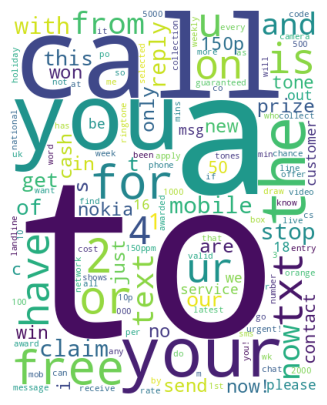

In [60]:
from collections import Counter

spam_text = df[df['label']==1]['sms'].dropna().str.cat(sep=" ")

spam_words = Counter(spam_text.split())
spam_wc = wc.generate_from_frequencies(spam_words)

plt.figure(figsize=(16,5))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()


Word Cloud of Ham Messages

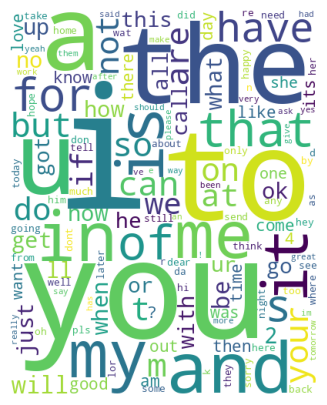

In [61]:

ham_text = df[df['label']==0]['sms'].dropna().str.cat(sep=" ")

ham_words = Counter(ham_text.split())
ham_wc = wc.generate_from_frequencies(ham_words)

plt.figure(figsize=(16,5))
plt.imshow(ham_wc)
plt.axis("off")
plt.show()

#Modeling

In [62]:
X=df['sms']
y=df['label']

In [63]:
X.head()

,sms
0,go until jurong point crazy available only in ...
1,ok lar joking wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...
3,u dun say so early hor u c already then say
4,nah i don t think he goes to usf he lives arou...


In [64]:
y.head()

,label
0,0
1,0
2,1
3,0
4,0


In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [66]:
X_train.shape

(4459,)

In [67]:
X_test.shape

(1115,)

Bag of words

In [68]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow=CountVectorizer(max_features=2000,ngram_range=(1, 2),min_df=2,max_df=0.90)

X_train_bow=bow.fit_transform(X_train).toarray()
X_test_bow=bow.transform(X_test).toarray()

Tf-IDF

In [69]:
tfidf=TfidfVectorizer(max_features=2000,ngram_range=(1, 2),min_df=2,max_df=0.90)
X_train_tfidf=tfidf.fit_transform(X_train).toarray()
X_test_tfidf=tfidf.transform(X_test).toarray()

In [70]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,ConfusionMatrixDisplay,classification_report

In [71]:

mnb = MultinomialNB(alpha= 0.1,fit_prior= False)

#Multinomial Naive Bayes

In [72]:
mnb.fit(X_train_tfidf,y_train)
y_pred = mnb.predict(X_test_tfidf)

train_accuracy=accuracy_score(y_train,mnb.predict(X_train_tfidf))
test_accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Overfitting gap:",train_accuracy-test_accuracy)

Accuracy: 0.9668161434977578
Overfitting gap: 0.012775693236936059


In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       966
           1       0.84      0.93      0.88       149

    accuracy                           0.97      1115
   macro avg       0.91      0.95      0.93      1115
weighted avg       0.97      0.97      0.97      1115



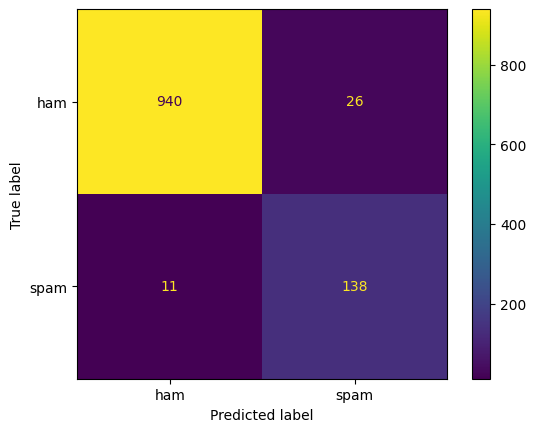

In [74]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['ham','spam']
)

disp.plot()
plt.show()

#Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lr.fit(X_train_tfidf, y_train)
y_pred2 = lr.predict(X_test_tfidf)
train_accuracy=accuracy_score(y_train,lr.predict(X_train_tfidf))
test_accuracy=accuracy_score(y_test,y_pred2)

print("Accuracy:",accuracy_score(y_test,y_pred2))
print("Overfitting gap:",train_accuracy-test_accuracy)

Accuracy: 0.9802690582959641
Overfitting gap: 0.008293399654248912


In [76]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.95      0.93       149

    accuracy                           0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



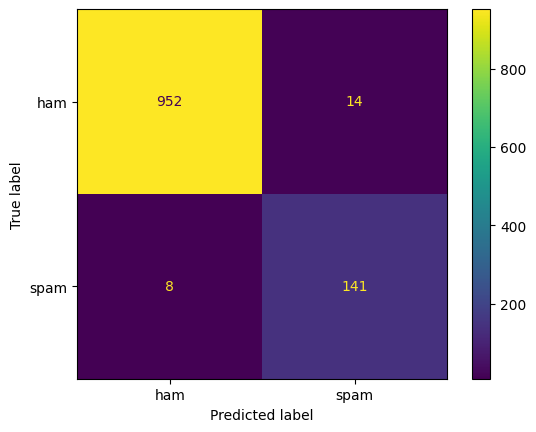

In [77]:
cm=confusion_matrix(y_test,y_pred2)
disp=ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['ham','spam']
)

disp.plot()
plt.show()

#Export Model

In [78]:
import joblib
joblib.dump(tfidf,"vectorizer.pkl")
joblib.dump(lr,"model.pkl")

In [79]:
from google.colab import files

In [80]:
files.download("vectorizer.pkl")

In [81]:
files.download("model.pkl")